In [2]:
import os 
import numpy as np
import gcutil
import sys 
import seaborn as sns
import pandas as pd

dir_xtb1 = "../data/benzoquinone_DB/xtb_opt/structures/bis-23/"
dir_xtb2 = "../data/benzoquinone_DB/xtb_opt/structures/bis-25/"
dir_xtb3 = "../data/benzoquinone_DB/xtb_opt/structures/bis-26/"
dir_xtb4 = "../data/benzoquinone_DB/xtb_opt/structures/mono/"
dir_xtb5 = "../data/benzoquinone_DB/xtb_opt/structures/tris/"
dir_dft1 = "../data/benzoquinone_DB/dft_opt/structures/bis-23/"
dir_dft2 = "../data/benzoquinone_DB/dft_opt/structures/bis-25/"
dir_dft3 = "../data/benzoquinone_DB/dft_opt/structures/bis-26/"
dir_dft4 = "../data/benzoquinone_DB/dft_opt/structures/mono/"
dir_dft5 = "../data/benzoquinone_DB/dft_opt/structures/tris/"
dir_array_dft = [dir_dft1,dir_dft2,dir_dft3,dir_dft4,dir_dft5]
dir_array_xtb = [dir_xtb1,dir_xtb2,dir_xtb3,dir_xtb4,dir_xtb5]
!ls


checkpoint	helpers.pyc		    selfies_util.pyc
descalc.py	molsimplify_util.py	    sklearn_utils.py
diagnose_db.py	molsimplify_util.pyc	    __tb
Element_PI.py	PersistentImages_Chemistry  test_files
Element_PI.pyc	PersistImages_Chemistry     vae_util.py
elements.py	Persist_util.py		    vae_util.pyc
elements.pyc	Persist_util.pyc	    xtb_vs_dft.ipynb
gcutil.py	__pycache__		    xyz2mol
geo		rdkit_tests.py
helpers.py	selfies_util.py


In [2]:


#iterate folders
for temp_ind,temp_dirs in enumerate(dir_array_dft):
    print("------------new folder------------------")
    dir_str_dft = "ls " + str(temp_dirs) + " | sort"
    dir_str_xtb = "ls " + str(dir_array_xtb[temp_ind]) + " | sort"

    temp_dft_files = os.popen(dir_str_dft).read()
    temp_xtb_files = os.popen(dir_str_xtb).read()
    
    temp_dft_files = temp_dft_files.split("\n")[:-1]
    temp_xtb_files = temp_xtb_files.split("\n")[:-1]
    #print(temp_dft_files)
    xtb_pos = []
    dft_pos = []
    rmse_array = []
    
    #iterate individual geometries
    for j,i in enumerate(temp_dft_files):
        try:
            # write to zmat - DFT
            stdoutOrigin=sys.stdout 
            sys.stdout = open("log_zmat.txt", "w")
            xyzarr, atomnames = gcutil.readxyz(temp_dirs + i)
            distmat = gcutil.distance_matrix(xyzarr)
            temp = gcutil.write_zmat(xyzarr, distmat, atomnames)
            sys.stdout.close()
            sys.stdout=stdoutOrigin
        except: 
            print("fails at xtb")
            print(i)

        #write back into xyz - DFT
        sys.stdout = open("log.txt", "w")
        atomnames, rconnect, rlist, aconnect, alist, dconnect, dlist = gcutil.readzmat("log_zmat.txt")
        gcutil.write_xyz(atomnames, rconnect, rlist, aconnect, alist, dconnect, dlist)
        sys.stdout.close()
        sys.stdout=stdoutOrigin
        
        try:
            # write to zmat - xTB
            sys.stdout = open("log_zmat_xtb.txt", "w")
            xyzarr, atomnames = gcutil.readxyz(dir_array_xtb[temp_ind] + i)
            distmat = gcutil.distance_matrix(xyzarr)
            temp = gcutil.write_zmat(xyzarr, distmat, atomnames)
            sys.stdout.close()
            sys.stdout=stdoutOrigin
        except:
            print("fails at dft")
            print(i)
        #write back into xyz - xTB
        sys.stdout = open("log_xtb.txt", "w")
        atomnames, rconnect, rlist, aconnect, alist, dconnect, dlist = gcutil.readzmat("log_zmat_xtb.txt")
        gcutil.write_xyz(atomnames, rconnect, rlist, aconnect, alist, dconnect, dlist)
        sys.stdout.close()
        sys.stdout=stdoutOrigin
        
        
        f_dft = open("log.txt","r")
        f_xtb = open("log_xtb.txt","r")
        lines_dft = list(f_dft)
        lines_xtb = list(f_xtb)
        
        
        sum_se = 0 
        for ind, i in enumerate(lines_dft):
            #print(lines_dft)
            #len(i[0:-2].split()) > 1 and
             
            if(len(i[0:-2].split()) > 1):

                try:
                    float(i[0:-2].split()[1])
                    dft_temp = [float(i) for i in i[0:-2].split()[1:]]
                    xtb_temp = [float(i) for i in lines_xtb[ind][0:-2].split()[1:]]
                    sum_se += (dft_temp[0] - xtb_temp[0])**2 + (dft_temp[1] - xtb_temp[1])**2 + (dft_temp[2] - xtb_temp[2])**2
                    
                except:
                    pass 
            else:
                atom_num = float(i)
        rmse_array.append(np.sqrt(sum_se / atom_num))
        f_dft.close()
        f_xtb.close()
        
rmse_array = np.array(rmse_array)
print("done!")

------------new folder------------------
------------new folder------------------
------------new folder------------------
------------new folder------------------
------------new folder------------------
done!


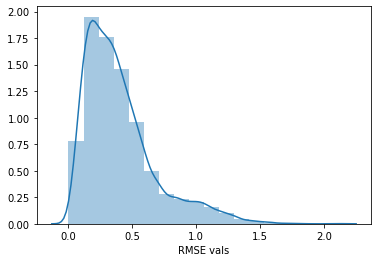

In [36]:
rmse_array = pd.Series(rmse_array, name = "RMSE vals")
sns.distplot(rmse_array,bins=18,norm_hist=True,kde = True)

In [29]:
print("Mean: " + str(np.mean(rmse_array)))
print("STD Dist. : " + str(np.std(rmse_array)))
print("number of molecules: " + str(np.shape(rmse_array)[0]))

Mean: 0.400872791127268
STD Dist. : 0.28054843613318475
number of molecules: 6106


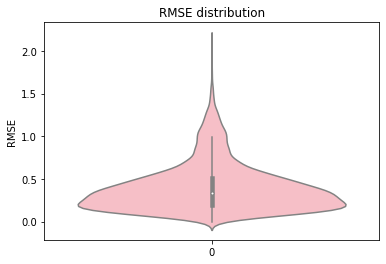

In [5]:
#ax = sns.stripplot(data = rmse_array)
ax = sns.violinplot( data=rmse_array,palette= ["lightpink"]).set(title='RMSE distribution', ylabel = "RMSE")

In [3]:
stdoutOrigin=sys.stdout 
sys.stdout = open("log_zmat.txt", "w")
sys.stdout.close()
sys.stdout=stdoutOrigin
print("yeet")

In [278]:
dft_pos = []
xtb_pos = []
print("somethign")

with open("log.txt") as file_dft:
    print("here or some shit")
    for num, line in enumerate(file_dft):
        print(line)
        if(len(line.split()) > 1):
            xtb_pos.append(line[:-2].split()[1:])
print("somethign")
with open("log_xtb.txt") as file_xtb:
    print(file_xtb)
    for num, line in enumerate(file_xtb):
        print(num)
        if(len(line.split()) > 1):
            dft_pos.append(line[:-2].split()[1:])
print(xtb_pos)
print(dft_pos)

In [ ]:
atom_xtb = {}
atom_dft = {}
xtb_pos_temp = []
dft_pos_temp = []
dft_pos = []
xtb_pos = []

with open(temp_dirs + i) as file_dft:
    for num, line in enumerate(file_dft):
        if(num > 1):
            xtb_pos.append(line[:-2].split()[1:])

with open(dir_array_xtb[temp_ind] + i) as file_xtb:
    for num, line in enumerate(file_xtb):
        if(num > 1):
            dft_pos.append(line[:-2].split()[1:])


for j,k in enumerate(dft_pos): 
    if (j == 0):
        atom_xtb["origin"] = np.array(xtb_pos[0]).astype(np.float)
        atom_dft["origin"] = np.array(k).astype(np.float)

    xtb_pos_temp.append(xtb_pos[j])
    dft_pos_temp.append(k)

atom_xtb["pos"] = np.array(xtb_pos_temp).astype(np.float) - atom_xtb["origin"]
atom_dft["pos"] = np.array(dft_pos_temp).astype(np.float) - atom_dft["origin"]        
a = np.array([1,0,0])
b_xtb = atom_xtb["pos"][1]
b_dft = atom_dft["pos"][1]

cosine_angle_xtb = np.dot(a, b_xtb) / (np.linalg.norm(a) * np.linalg.norm(b_xtb))
cosine_angle_dft = np.dot(a, b_dft) / (np.linalg.norm(a) * np.linalg.norm(b_dft))

angle_xtb = np.arccos(cosine_angle_xtb)
angle_dft = np.arccos(cosine_angle_dft)

print(np.degrees(angle_xtb))
print(np.degrees(angle_dft))



In [5]:
import pandas as pd 

#reference 


df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_rdkit.pkl")
#df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_rdkit.h5")
print(df["diff"])
print(df["HOMO"])
print(df["HOMO-1"])

df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_morg.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_auto.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_aval.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_persist.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_vae.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_self.pkl")
df.to_pickle(str)
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_layer.pkl")
df.to_pickle(str)


df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_morg.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_auto.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_aval.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_persist.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_vae.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_self.h5")
df.to_hdf(str, key="df", mode='a')
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_layer.h5")
df.to_hdf(str, key="df", mode='a')

0    0.073743
1    0.074309
2    0.075135
3     0.06857
4    0.073827
Name: diff, dtype: object


In [13]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_rdkit.pkl")
print(df.head())

                     name                                                mat  \
0            Br_Br_Br.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   Br_Br_C2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  Br_Br_CC2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      Br_Br_C(C)(C)C.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4            Br_Br_CC.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.073743  
1 -0.196519 -0.12221  0.074309  
2 -0.195905 -0.12077  0.075135  
3  -0.18831 -0.11974   0.06857  
4 -0.191877 -0.11805  0.073827  


In [12]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_morg.pkl")
print(df.head())

                     name                                                mat  \
0            Br_Br_Br.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   Br_Br_C2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  Br_Br_CC2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      Br_Br_C(C)(C)C.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4            Br_Br_CC.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.073743  
1 -0.196519 -0.12221  0.074309  
2 -0.195905 -0.12077  0.075135  
3  -0.18831 -0.11974   0.06857  
4 -0.191877 -0.11805  0.073827  


In [11]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_aval.pkl")
print(df.head())

                     name                                                mat  \
0            Br_Br_Br.sdf  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
1   Br_Br_C2=CC=CC=C2.sdf  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
2  Br_Br_CC2=CC=CC=C2.sdf  [1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...   
3      Br_Br_C(C)(C)C.sdf  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...   
4            Br_Br_CC.sdf  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.073743  
1 -0.196519 -0.12221  0.074309  
2 -0.195905 -0.12077  0.075135  
3  -0.18831 -0.11974   0.06857  
4 -0.191877 -0.11805  0.073827  


In [9]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_layer.pkl")
print(df.head())

                     name                                                mat  \
0            Br_Br_Br.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   Br_Br_C2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  Br_Br_CC2=CC=CC=C2.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      Br_Br_C(C)(C)C.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4            Br_Br_CC.sdf  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.073743  
1 -0.196519 -0.12221  0.074309  
2 -0.195905 -0.12077  0.075135  
3  -0.18831 -0.11974   0.06857  
4 -0.191877 -0.11805  0.073827  


In [8]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_self.pkl")
print(df.head())

df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_self.h5")
print(df.head())

                                    name  \
0         C1(=O)C(=C(C(=O)C(=C1)Br)Br)Br   
1   C1(=O)C(=C(C(=O)C(=C1)Br)Br)c1ccccc1   
2  C1(=O)C(=C(C(=O)C(=C1)Br)Br)Cc1ccccc1   
3  C1(=C[C](C(=O)C(=C1C(C)(C)C)Br)Br)[O]   
4         C1(=O)C(=C(C(=O)C(=C1)Br)Br)CC   

                                                 mat HOMO HOMO-1 diff  
0  [C][Branch1_3][epsilon][=O][C][Branch1_3][#N][...                   
1  [C][Branch1_3][epsilon][=O][C][Branch1_3][#N][...                   
2  [C][Branch1_3][epsilon][=O][C][Branch1_3][#N][...                   
3  [C][Branch2_3][epsilon][Branch1_2][=C][Cexpl][...                   
4  [C][Branch1_3][epsilon][=O][C][Branch1_3][#N][...                   
                                    name  \
0         C1(=O)C(=C(C(=O)C(=C1)Br)Br)Br   
1   C1(=O)C(=C(C(=O)C(=C1)Br)Br)c1ccccc1   
2  C1(=O)C(=C(C(=O)C(=C1)Br)Br)Cc1ccccc1   
3  C1(=C[C](C(=O)C(=C1C(C)(C)C)Br)Br)[O]   
4         C1(=O)C(=C(C(=O)C(=C1)Br)Br)CC   

                                      

In [7]:
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_vae.h5")
print(df.head())
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_vae.pkl")
print(df.head())

                                                 mat                    name
0  [[-0.9732547, 0.6579669, -1.3522831, 0.6810056...            Br_Br_Br.xyz
1  [[-0.8016323, 0.83916795, -1.8035296, 1.000743...   Br_Br_C2=CC=CC=C2.xyz
2  [[-0.5272166, 0.8281526, -1.5160015, 0.9529316...  Br_Br_CC2=CC=CC=C2.xyz
3  [[0.087641895, -0.92037755, 0.25641298, 0.1550...      Br_Br_C(C)(C)C.xyz
4  [[-0.30556712, 1.1312592, -0.40703785, 1.93495...            Br_Br_CC.xyz
                                                 mat                    name  \
0  [[-0.9732547, 0.6579669, -1.3522831, 0.6810056...            Br_Br_Br.xyz   
1  [[-0.8016323, 0.83916795, -1.8035296, 1.000743...   Br_Br_C2=CC=CC=C2.xyz   
2  [[-0.5272166, 0.8281526, -1.5160015, 0.9529316...  Br_Br_CC2=CC=CC=C2.xyz   
3  [[0.087641895, -0.92037755, 0.25641298, 0.1550...      Br_Br_C(C)(C)C.xyz   
4  [[-0.30556712, 1.1312592, -0.40703785, 1.93495...            Br_Br_CC.xyz   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.

In [5]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_persist.pkl")
print(df.head())
df = pd.read_hdf("../data/desc/DB2/desc_calc_DB2_persist.h5")
print(df.head())

                                       name  \
0   C2=CC=CC=C2_C2=CC=CC=C2_C2=CC=CC=C2.xyz   
1  C2=CC=CC=C2_C2=CC=CC=C2_CC2=CC=CC=C2.xyz   
2      C2=CC=CC=C2_C2=CC=CC=C2_C(C)(C)C.xyz   
3            C2=CC=CC=C2_C2=CC=CC=C2_CC.xyz   
4      C2=CC=CC=C2_C2=CC=CC=C2_C(F)(F)F.xyz   

                                                 mat  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
                                       name  \
0   C2=CC=CC=C2_C2=CC=CC=C2_C2=CC=CC=C2.xyz   
1  C2=CC=CC=C2_C2=CC=CC=C2_CC2=CC=CC=C2.xyz   
2      C2=CC=CC=C2_C2=CC=CC=C2_C(C)(C)C.xyz   
3            C2=CC=CC=C2_C2=CC=CC=C2_CC.xyz   
4      C2=CC=CC=C2_C2=CC=CC=C2_C(F)(F)F.xyz   

                                                 mat      HOMO   HOMO-1  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 

In [14]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_auto.pkl")
print(df.head())


                                           name  \
0                   ../data/xyz/DB2/C(=O)OC.xyz   
1           ../data/xyz/DB2/C(=O)OC_C(=O)OC.xyz   
2   ../data/xyz/DB2/C(=O)OC_C(=O)OC_C(=O)OC.xyz   
3  ../data/xyz/DB2/C(=O)OC_C(=O)OC_C(C)(C)C.xyz   
4  ../data/xyz/DB2/C(=O)OC_C(=O)OC_C(F)(F)F.xyz   

                                                 mat      HOMO   HOMO-1  \
0  [[128.39440000000002, 246.07500000000002, 387.... -0.221399  -0.1614   
1  [[174.74660000000003, 334.15200000000004, 537.... -0.211996  -0.1482   
2  [[221.0988, 422.229, 687.3006000000003, 704.80... -0.198261 -0.13556   
3  [[239.47660000000005, 475.9320000000001, 807.2... -0.186499 -0.12502   
4  [[223.9303, 396.831, 697.0288000000002, 692.21...  -0.19791 -0.13501   

       diff  
0  0.059999  
1  0.063796  
2  0.062701  
3  0.061479  
4    0.0629  


In [21]:
df = pd.read_pickle("../data/desc/DB2/desc_calc_DB2_vae.pkl")
print(df.head())

                                                 mat                    name  \
0  [[-0.9732547, 0.6579669, -1.3522831, 0.6810056...            Br_Br_Br.xyz   
1  [[-0.8016323, 0.83916795, -1.8035296, 1.000743...   Br_Br_C2=CC=CC=C2.xyz   
2  [[-0.5272166, 0.8281526, -1.5160015, 0.9529316...  Br_Br_CC2=CC=CC=C2.xyz   
3  [[0.087641895, -0.92037755, 0.25641298, 0.1550...      Br_Br_C(C)(C)C.xyz   
4  [[-0.30556712, 1.1312592, -0.40703785, 1.93495...            Br_Br_CC.xyz   

       HOMO   HOMO-1      diff  
0 -0.200233 -0.12649  0.073743  
1 -0.196519 -0.12221  0.074309  
2 -0.195905 -0.12077  0.075135  
3  -0.18831 -0.11974   0.06857  
4 -0.191877 -0.11805  0.073827  
